In [16]:
import ngmix
import matplotlib.pyplot as plt
import galsim
import numpy as np

def select(data, shear_type):
    """
    select the data by shear type and size
    Parameters
    ----------
    data: array
        The array with fields shear_type and T
    shear_type: str
        e.g. 'noshear', '1p', etc.
    Returns
    -------
    array of indices
    """

    w, = np.where(
        (data['flags'] == 0) & (data['shear_type'] == shear_type)
    )
    return w

def make_struct(res, obs, shear_type):
    """
    make the data structure
    Parameters
    ----------
    res: dict
        With keys 's2n', 'e', and 'T'
    obs: ngmix.Observation
        The observation for this shear type
    shear_type: str
        The shear type
    Returns
    -------
    1-element array with fields
    """
    dt = [
        ('flags', 'i4'),
        ('shear_type', 'U7'),
        ('s2n', 'f8'),
        ('g', 'f8', 2),
        ('T', 'f8'),
        ('Tpsf', 'f8'),
    ]
    data = np.zeros(1, dtype=dt)
    data['shear_type'] = shear_type
    data['flags'] = res['flags']
    if res['flags'] == 0:
        data['s2n'] = res['s2n']
        # for moments we are actually measureing e, the elliptity
        data['g'] = res['e']
        data['T'] = res['T']
    else:
        data['s2n'] = np.nan
        data['g'] = np.nan
        data['T'] = np.nan
        data['Tpsf'] = np.nan

        # we only have one epoch and band, so we can get the psf T from the
        # observation rather than averaging over epochs/bands
        data['Tpsf'] = obs.psf.meta['result']['T']
    return data


In [17]:
import ngmix
import matplotlib.pyplot as plt
import galsim
import numpy as np

def select(data, shear_type):
    """
    select the data by shear type and size
    Parameters
    ----------
    data: array
        The array with fields shear_type and T
    shear_type: str
        e.g. 'noshear', '1p', etc.
    Returns
    -------
    array of indices
    """

    w, = np.where(
        (data['flags'] == 0) & (data['shear_type'] == shear_type)
    )
    return w

def make_struct(res, obs, shear_type):
    """
    make the data structure
    Parameters
    ----------
    res: dict
        With keys 's2n', 'e', and 'T'
    obs: ngmix.Observation
        The observation for this shear type
    shear_type: str
        The shear type
    Returns
    -------
    1-element array with fields
    """
    dt = [
        ('flags', 'i4'),
        ('shear_type', 'U7'),
        ('s2n', 'f8'),
        ('g', 'f8', 2),
        ('T', 'f8'),
        ('Tpsf', 'f8'),
    ]
    data = np.zeros(1, dtype=dt)
    data['shear_type'] = shear_type
    data['flags'] = res['flags']
    if res['flags'] == 0:
        data['s2n'] = res['s2n']
        # for moments we are actually measureing e, the elliptity
        data['g'] = res['e']
        data['T'] = res['T']
    else:
        data['s2n'] = np.nan
        data['g'] = np.nan
        data['T'] = np.nan
        data['Tpsf'] = np.nan

        # we only have one epoch and band, so we can get the psf T from the
        # observation rather than averaging over epochs/bands
        data['Tpsf'] = obs.psf.meta['result']['T']
    return data
def make_data(rng, noise, shear, version=0, first=False):
    """
    simulate an exponential object with moffat psf
    Parameters
    ----------
    rng: np.random.RandomState
        The random number generator
    noise: float
        Noise for the image
    shear: (g1, g2)
        The shear in each component
    Returns
    -------
    ngmix.Observation
    """

    scale    = 0.263
    psf_fwhm = 0.9
    gal_hlr  = 0.5
    dy, dx   = rng.uniform(low=-scale/2, high=scale/2, size=2)

    psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm,
    ).shear(g1=0.02, g2=-0.01,)
    
    
    obj0 = galsim.Exponential(
        half_light_radius=gal_hlr, flux=125e3
    ).shear(
        g1=shear[0],
        g2=shear[1],
    ).shift(dx=dx, dy=dy,)
    obj = galsim.Convolve(psf, obj0)

    psf_im = psf.drawImage(scale=scale).array
    im = obj.drawImage(scale = scale)
 
    # psf noise
    psf_noise= 1e-9
    psf_im += rng.normal(scale=psf_noise, size=psf_im.shape)
    
    backgrounds = []
    
    if version==0:
        noise_image_1 = rng.normal(scale=noise, size=im.array.shape)
        im += noise_image_1
        random = galsim.BaseDeviate()
        fake_var_image = im*0 + (noise)**2
        fakeVarNoise = galsim.VariableGaussianNoise(random, fake_var_image)
        
        if first:
            backgrounds.append(fake_var_image.array)
            
            
    if version==1:
        random = galsim.BaseDeviate(
        var_image = im + (noise)**2
        
        
        varNoise = galsim.VariableGaussianNoise(random, var_image)
        im.addNoise(varNoise)
        
        if first:
            backgrounds.append(var_image.array)
            
    
    imArr = im.array
    
    cen = (np.array(imArr.shape)-1.0)/2.0
    psf_cen = (np.array(psf_im.shape)-1.0)/2.0
    jacobian = ngmix.DiagonalJacobian(
        row=cen[0] + dy/scale, col=cen[1] + dx/scale, scale=scale,
    )
    psf_jacobian = ngmix.DiagonalJacobian(
        row=psf_cen[0], col=psf_cen[1], scale=scale,
    )

    # noise variance map
    if version==0:
        wt = imArr*0 + 1.0/(noise)**2
    if version==1:
        wt = 1.0/var_image.array
        
    psf_wt = psf_im*0 + 1.0/psf_noise**2

    psf_obs = ngmix.Observation(
        psf_im,
        weight=psf_wt,
        jacobian=psf_jacobian,
    )
    obs = ngmix.Observation(
        imArr,
        weight=wt,
        jacobian=jacobian,
        psf=psf_obs,
    )
    return obs, backgrounds

In [18]:
def analyze(rng, num_tests, num_gals, noise_level, shear_true, version=0, first=False):
    data = []
    x = []
    y = []
    shear_error = []
    s2n_error = []
    backgrounds = []
    
    for i in range(num_tests):
        print("len(data[]) =", len(data))
        dlist = []
        
        #makes first true for every new noise value
        if first is False:
            first = True
        
        for j in range(num_gals):
            imgdata = make_data(rng=rng, noise=noise_level[i], shear=shear_true, version=version, first = first)
            obs = imgdata[0]
            
            if(len(imgdata[1]) > 0):
                backgrounds.append(imgdata[1][0])
                
                            
            if first is True:
                first = False
                
            resdict, obsdict = boot.go(obs)
            for stype, sres in resdict.items():
                st = make_struct(res=sres, obs=obsdict[stype], shear_type=stype)
                dlist.append(st)
                
        data.append(np.hstack(dlist))
        #data contains average of all galaxy data
        
        w = select(data=data[i], shear_type='noshear')
        w_1p = select(data=data[i], shear_type='1p')
        w_1m = select(data=data[i], shear_type='1m')
        g_1p = data[i]['g'][w_1p, 0].mean()
        g_1m = data[i]['g'][w_1m, 0].mean()
        R11 = (g_1p - g_1m)/0.02
        
        s2n = data[i]['s2n'][w].mean()
        s2n_err = data[i]['s2n'][w].std(axis=0)/np.sqrt(w.size)
        s2n_error.append(s2n_err)
        
        g = data[i]['g'][w].mean(axis=0)
        shear = g / R11
        
        g_error = data[i]['g'][w].std(axis=0) / np.sqrt(w.size)
        shear_error.append(g_error[0]/R11)
        
        x.append(s2n)
        y.append(shear[0])
            
    return (x, y, s2n_error, shear_error, backgrounds)

In [19]:
rng = np.random.RandomState(1024)
#rng = galsim.BaseDeviate(1024)

# We will measure moments with a fixed gaussian weight function
weight_fwhm= 1.2
fitter     = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner     = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both psf
# and object measurements
#
# We will just do R11 for simplicity and to speed up this example;
# typically the off diagonal terms are negligible, and R11 and R22 are
# usually consistent
boot      = ngmix.metacal.MetacalBootstrapper(
    runner= runner, psf_runner=psf_runner,
    rng=rng,
    psf='gauss',
    types=['noshear', '1p', '1m'],
)

len(data[]) = 0
len(data[]) = 1
len(data[]) = 2
len(data[]) = 3
len(data[]) = 4
x = [1001.3042011198064, 316.7261299829428, 100.05492320995596, 31.595363403949314, 10.0496703732729]
y = [0.010265130380548297, 0.010390161532228387, 0.009341959422604561, 0.010563088696244945, 0.02213142587274775]
xerr = [0.10944250849479586, 0.11914936315513354, 0.1281833406472535, 0.11876940607358544, 0.12074743246058253]
yerr = [0.00031363591001485263, 0.0011367836665940431, 0.0033141872642576146, 0.009482870344344143, 0.031485022770771656]


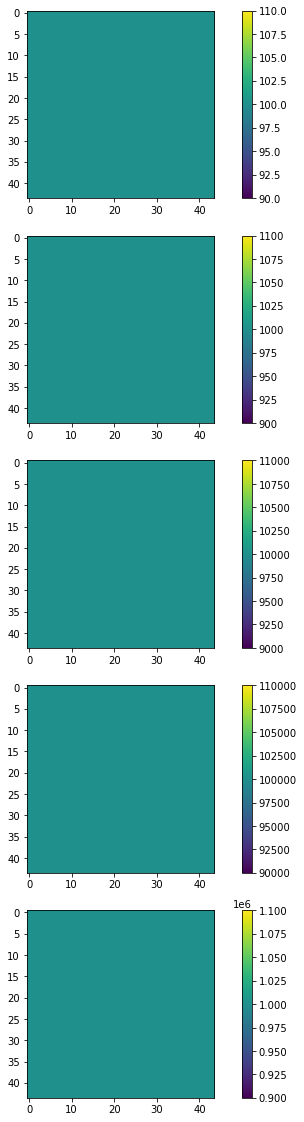

In [20]:
noise_arr = 1e5*np.logspace(-4, -2, 5, base=10.0)
num_tests = len(noise_arr)
num_gals = 100
shear_true = [0.01, 0.00]
ans1 = analyze(rng, num_tests, num_gals, noise_arr, shear_true, version=0, first = True)
backgrounds = ans1[4]
print("x =", ans1[0])
print("y =", ans1[1])
print("xerr =", ans1[2])
print("yerr =", ans1[3])
plt.close()
fig = plt.figure(figsize=(10, 20))

for i in range(len(backgrounds)):
    sub = fig.add_subplot(len(backgrounds), 1, i + 1)
    plot = sub.imshow(backgrounds[i])
    fig.colorbar(plot)

len(data[]) = 0
random num = galsim.BaseDeviate('1454338328 3127705566 2968628686 ... 1503398469 3555357506 2784248852')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('4143386983 1367629941 2483298758 ... 514997398 1859661724 4128297056')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('2184350882 3281197857 4168935020 ... 4121129496 3830020629 32305949')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('3306698040 262574920 3095503722 ... 738144188 2321380250 3806524775')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('3814622465 3297151947 3160092138 ... 2571067645 2615328265 2926960582')
random with seed = g

random num = galsim.BaseDeviate('2677627066 352483481 1957852511 ... 1644169267 4291035176 4053276262')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('2035398806 1495769748 2964840907 ... 3463701080 207094613 3956592632')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('366257246 2406295319 3985483851 ... 2131907895 240092860 866043547')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('504284502 1892212975 2384600040 ... 3567525469 898780036 767390083')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('1624867526 608049028 3685804822 ... 1938133828 845547943 889008210')
random with seed = galsim.BaseDeviate('172

random num = galsim.BaseDeviate('1840839189 2388352485 345877285 ... 1943163974 2198225265 1487101902')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('4143638218 3523059278 1658956131 ... 2863558823 1637728391 3136204109')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('3203467245 1574963276 2750380899 ... 300460380 82907066 3667640529')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('1326475368 540566126 4226659176 ... 2672810510 2625991978 1081189175')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('2084349028 2460608730 1217164602 ... 3256773695 596693530 1061736625')
random with seed = galsim.BaseDeviate

random num = galsim.BaseDeviate('2711468896 2754633643 2481335983 ... 3016891502 3121546506 4107683479')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('507564375 217785940 48567078 ... 3816839502 1586000591 1558678453')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('957048614 1975322623 4241298744 ... 3786068983 796865970 1623880617')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('3087402343 2500210138 2061545018 ... 3075884146 2662920862 185677307')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('1286176193 1667914945 2916702146 ... 579075357 1750229983 2735027973')
random with seed = galsim.BaseDeviate('

random num = galsim.BaseDeviate('417590511 440492364 301010686 ... 762366963 1649050701 1447485547')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('569932358 1080144799 1090349912 ... 3910032614 3366204871 837491907')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('578168100 108587829 235350251 ... 83823930 1263158352 2098417508')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('3662277428 1351302068 1205169003 ... 561015934 2061254180 2770949128')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('3540352495 855767581 1097609843 ... 4076934919 3319479042 1796788948')
random with seed = galsim.BaseDeviate('17221

random num = galsim.BaseDeviate('1082844591 2071509927 2090327680 ... 1141894162 3626193133 3401600597')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
len(data[]) = 2
random num = galsim.BaseDeviate('1542788769 2402127137 2104846801 ... 1857733090 2997222397 3343967498')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('2171929481 1859963096 4001783455 ... 1422208115 1169263976 2912484828')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('260862008 4227743257 624978500 ... 2169680091 2821908747 3322594300')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('4000916104 2132018136 2145625503 ... 468354795 1512570917 718754979')
random with seed = 

random num = galsim.BaseDeviate('1387038194 526705632 467715938 ... 565740840 2435248950 3002124787')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('434582261 3006216106 1543626058 ... 2918384550 4149163554 1562314356')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('131561262 285975335 3724033381 ... 2573254455 3757166423 3718693523')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('1346365952 2943933286 399708790 ... 3779526830 3776633775 3235625291')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('2018986238 3279504284 4049650877 ... 1430095408 3849137347 709192239')
random with seed = galsim.BaseDeviate('

random num = galsim.BaseDeviate('3117284645 3939483492 2167775909 ... 1058617348 2617851906 1122386543')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('2957948184 2578341187 3933836199 ... 2370630410 4070780054 558847544')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('850323006 199885943 1123578357 ... 3166726146 1200687726 4158097210')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('329383535 958122188 4093600894 ... 3600093158 2039731399 1838869133')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('2632317652 500333679 2745925325 ... 259406707 2207973837 1086881818')
random with seed = galsim.BaseDeviate(

random num = galsim.BaseDeviate('1210788399 568082983 2120087653 ... 363894173 1644629599 2148203397')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('3994056263 2812611797 2245926869 ... 1600660632 3957019595 399906903')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('1841090278 1921531940 1998068635 ... 905847842 2743629272 3168676721')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('1925483914 4195891928 2735434601 ... 3144165129 1648970949 3395039171')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('830505766 3958182911 3491675758 ... 4249555960 2351773557 952537954')
random with seed = galsim.BaseDeviate

random num = galsim.BaseDeviate('2477306540 3555695783 1356370102 ... 2411508519 861175047 3597604146')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('3886452324 3753659812 2657747429 ... 2290461155 4123816243 3129694815')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('1337469463 1892180143 3347923624 ... 1093697918 3421048969 3633537761')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('2720536260 2506813983 160303731 ... 313710071 584096737 2397039412')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('444015009 157707654 212855776 ... 2237960418 3897887438 4092590672')
random with seed = galsim.BaseDeviate(

random num = galsim.BaseDeviate('4061502805 2836666607 549431939 ... 1192213629 3967269722 166628748')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('4017098550 902585578 3653231188 ... 2391905838 3556888010 139838396')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('4098151237 2200031391 3309720307 ... 475617450 609810304 3087869935')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('1595310738 633810688 3367799554 ... 1366238089 4086615830 1109062328')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('2455252967 3652153946 1926807071 ... 872157010 1776480200 2472160700')
random with seed = galsim.BaseDeviate('

random num = galsim.BaseDeviate('2658379438 2256981469 3967062013 ... 3763612677 1223595724 275789392')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('706155315 4274380320 1055284945 ... 206282321 3519402339 3652713807')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('3924037803 2826730057 312173209 ... 2904017520 2799166312 1271297345')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('251223132 2974985293 1040007725 ... 993605875 263357773 3688877776')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('664759221 1081891690 2716423225 ... 2301285153 2463631933 1752220746')
random with seed = galsim.BaseDeviate('

random num = galsim.BaseDeviate('2161182025 2002336152 4113930847 ... 2913420260 3919438380 2896061946')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('1139355993 265326521 3561075967 ... 3205107036 3316684420 2431296690')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('1625109367 3356062607 862224958 ... 3621877960 3341176197 3091418701')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('3363075564 1989701196 3712334179 ... 503609945 564979851 3514246214')
random with seed = galsim.BaseDeviate('1722140265 2204954377 1395929689 ... 1855140663 2499091644 3796371301')
random num = galsim.BaseDeviate('1373305306 3021457000 3950379476 ... 2670811280 987502088 4208393111')
random with seed = galsim.BaseDeviat

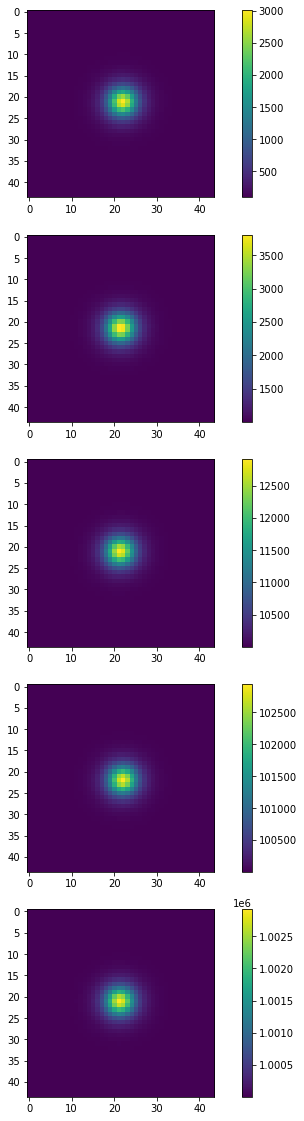

In [21]:
ans2 = analyze(rng, num_tests, num_gals, noise_arr, shear_true, version=1, first = True)
backgrounds = ans2[4]
print("x =", ans2[0])
print("y =", ans2[1])
print("xerr =", ans2[2])
print("yerr =", ans2[3])

fig = plt.figure(figsize=(10, 20))

for i in range(len(backgrounds)):
    sub = fig.add_subplot(len(backgrounds), 1, i + 1)
    plot = sub.imshow(backgrounds[i])
    fig.colorbar(plot)

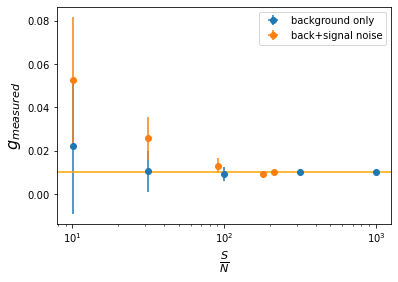

In [22]:
plt.errorbar(ans1[0], ans1[1], xerr=ans1[2], yerr=ans1[3], fmt='o', label='background only')
plt.errorbar(ans2[0], ans2[1], xerr=ans2[2], yerr=ans2[3], fmt='o', label='back+signal noise')
plt.axhline(shear_true[0], color="orange")
plt.xscale("log")
plt.xlabel(r'$\frac{S}{N}$', fontsize=16)
plt.ylabel(r'$g_{measured}$', fontsize=16)
plt.legend()

In [23]:
"""
im_noiseNormal = im
im_noiseVariable = im
galList.append(im_noiseNormal.array)
galList.append(im_noiseVariable.array)
galList.append(im.array)
for i in range(3):
    plt.imshow(galList[i])
    
plt.plot(im_noiseNormal)
plt.plot(im_noiseVariable.array)
plt.plot(im.array)

plt.show()
"""


def drawGal(pick):
    
    scale    = 0.263
    psf_fwhm = 0.9
    gal_hlr  = 0.5
    noise = 0.001
    random = galsim.BaseDeviate(1000)
    
    psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm,).shear(g1=0, g2=0,)
    
    
    obj0 = galsim.Exponential(half_light_radius=gal_hlr)
    
    obj = galsim.Convolve(psf, obj0)

    im = obj.drawImage(scale=scale)
    image = im

    """
    if(pick == 1):
        im += rng.normal(scale=noise, size=im.array.shape)
    if(pick == 4):
    gaussian_noise = galsim.GaussianNoise(random, sigma=noise*3)
    im.addNoise(gaussian_noise)
    """
        
    if(pick == 2):
        var_image= im + (noise)**2
        #varNoise = galsim.VariableGaussianNoise(random, var_image)
        #im.addNoise(varNoise)
        image = var_image

    if(pick == 3):
        other_var_image = im*0 + (noise)**2
        #otherVarNoise = galsim.VariableGaussianNoise(random, other_var_image)
        #im.addNoise(otherVarNoise)
        image = other_var_image
        
    
    return(plt.imshow(image.array), plt.colorbar())

(<matplotlib.image.AxesImage at 0x12f2566a0>,
 <matplotlib.colorbar.Colorbar at 0x12f270970>)

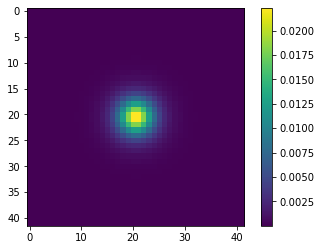

In [59]:
drawGal(0)

(<matplotlib.image.AxesImage at 0x12f396e80>,
 <matplotlib.colorbar.Colorbar at 0x12f3bb220>)

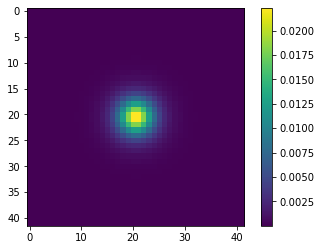

In [60]:
drawGal(2)

(<matplotlib.image.AxesImage at 0x12f4e38b0>,
 <matplotlib.colorbar.Colorbar at 0x12f4feb50>)

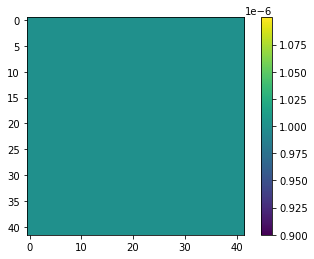

In [61]:
drawGal(3)